In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bandarunagasaidhanya","key":"dd10939f45ecb4e5378165e254b12e2a"}'}

In [2]:
import os
import shutil

# Create .kaggle folder if not exists
os.makedirs("/root/.kaggle", exist_ok=True)

# Move kaggle.json to the correct directory
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# Set proper permissions
os.chmod("/root/.kaggle/kaggle.json", 600)

In [3]:
#!/bin/bash
!kaggle datasets download dmitrybabko/speech-emotion-recognition-en

Dataset URL: https://www.kaggle.com/datasets/dmitrybabko/speech-emotion-recognition-en
License(s): copyright-authors


In [4]:
import zipfile

zip_path = "/content/speech-emotion-recognition-en.zip"  # Full path to your ZIP file
extract_path = "/content/"  # Destination folder

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipping completed!")

Unzipping completed!


In [5]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import tensorflow as tf

# Fix imports for Keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, BatchNormalization, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

# Other necessary imports
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import IPython.display as ipd
from IPython.display import Audio

# Ignore warnings
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

print("Done")


Done


In [6]:
!apt-get update
!apt-get install -y libsndfile1

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,381 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,684 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,538 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.

# Importing Data

In [7]:
#preparing data set

ravdess = "/content/Ravdess/audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_23', 'Actor_08', 'Actor_18', 'Actor_12', 'Actor_21', 'Actor_15', 'Actor_11', 'Actor_06', 'Actor_20', 'Actor_01', 'Actor_05', 'Actor_10', 'Actor_09', 'Actor_24', 'Actor_02', 'Actor_13', 'Actor_16', 'Actor_22', 'Actor_14', 'Actor_04', 'Actor_19', 'Actor_07', 'Actor_17', 'Actor_03']


In [8]:
Crema = "/content/Crema/"
Tess = "/content/Tess/"
Savee = "/content/Savee/"

# preprocessing

**Ravdees**

In [9]:
file_emotion = []
file_path = []
for i in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(ravdess + i)
    for f in actor:
        part = f.split('.')[0].split('-')
    # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + i + '/' + f)


In [10]:
print(actor[0])
print(part[0])
print(file_path[0])
print(int(part[2]))
print(f)

03-01-07-02-02-02-03.wav
03
/content/Ravdess/audio_speech_actors_01-24/Actor_23/03-01-02-02-02-02-23.wav
3
03-01-03-02-02-01-03.wav


In [11]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
print(ravdess_df.head())
print("______________________________________________")
print(ravdess_df.tail())
print("_______________________________________________")
print(ravdess_df.Emotions.value_counts())



  Emotions                                               Path
0  neutral  /content/Ravdess/audio_speech_actors_01-24/Act...
1  neutral  /content/Ravdess/audio_speech_actors_01-24/Act...
2  neutral  /content/Ravdess/audio_speech_actors_01-24/Act...
3  disgust  /content/Ravdess/audio_speech_actors_01-24/Act...
4    angry  /content/Ravdess/audio_speech_actors_01-24/Act...
______________________________________________
     Emotions                                               Path
1435      sad  /content/Ravdess/audio_speech_actors_01-24/Act...
1436  neutral  /content/Ravdess/audio_speech_actors_01-24/Act...
1437  neutral  /content/Ravdess/audio_speech_actors_01-24/Act...
1438    angry  /content/Ravdess/audio_speech_actors_01-24/Act...
1439    happy  /content/Ravdess/audio_speech_actors_01-24/Act...
_______________________________________________
Emotions
neutral     288
disgust     192
angry       192
surprise    192
fear        192
sad         192
happy       192
Name: count, dtype: in

<ipython-input-11-2e26f59c975e>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',


**Crema DataFrame**

In [12]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())


Emotions
happy      1271
fear       1271
angry      1271
disgust    1271
sad        1271
neutral    1087
Name: count, dtype: int64


**TESS dataset**

In [13]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())


Emotions
disgust     400
sad         400
neutral     400
angry       400
surprise    400
fear        400
happy       400
Name: count, dtype: int64


**SAVEE Dataset**

In [14]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
print(Savee_df.Emotions.value_counts())


Emotions
neutral     120
disgust      60
sad          60
surprise     60
fear         60
angry        60
happy        60
Name: count, dtype: int64


**Integration**

In [15]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,neutral,/content/Ravdess/audio_speech_actors_01-24/Act...
1,neutral,/content/Ravdess/audio_speech_actors_01-24/Act...
2,neutral,/content/Ravdess/audio_speech_actors_01-24/Act...
3,disgust,/content/Ravdess/audio_speech_actors_01-24/Act...
4,angry,/content/Ravdess/audio_speech_actors_01-24/Act...


In [16]:
print(data_path.Emotions.value_counts())


Emotions
disgust     1923
angry       1923
fear        1923
happy       1923
sad         1923
neutral     1895
surprise     652
Name: count, dtype: int64


>*                           Data Visualisation and Exploration

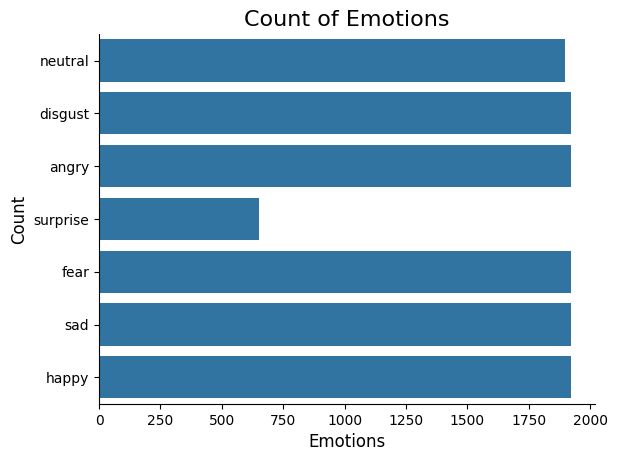

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [18]:
data,sr = librosa.load(file_path[0])
sr

22050

In [19]:
ipd.Audio(data,rate=sr)

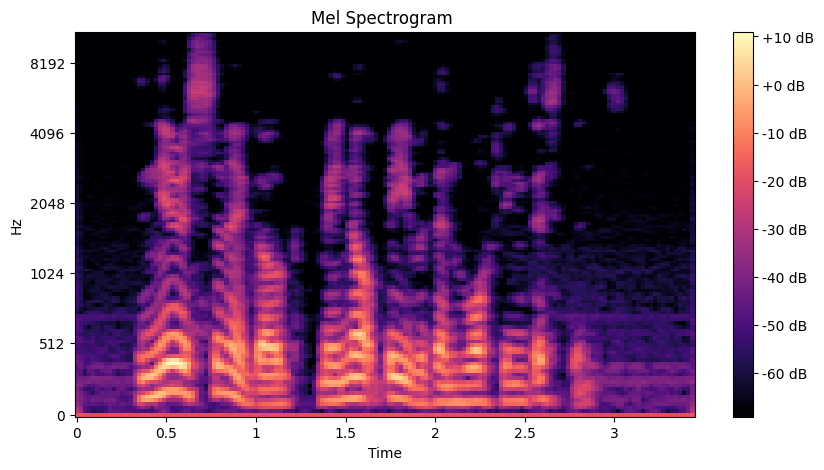

In [20]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

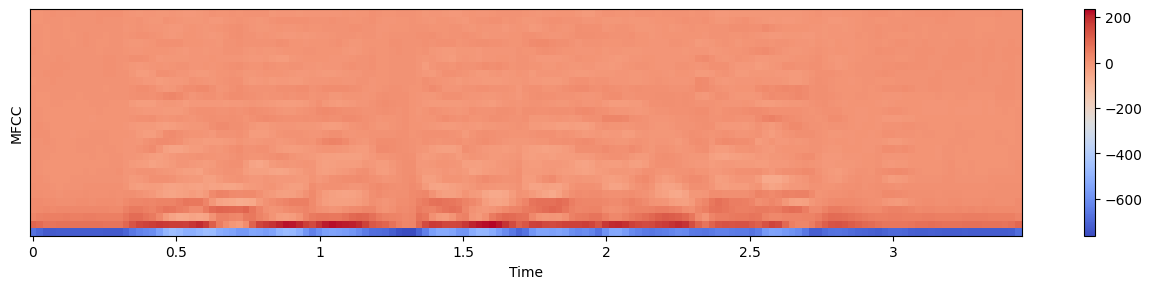

In [21]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data,rate=sr)

# Data augmentation

In [22]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, sr=rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)



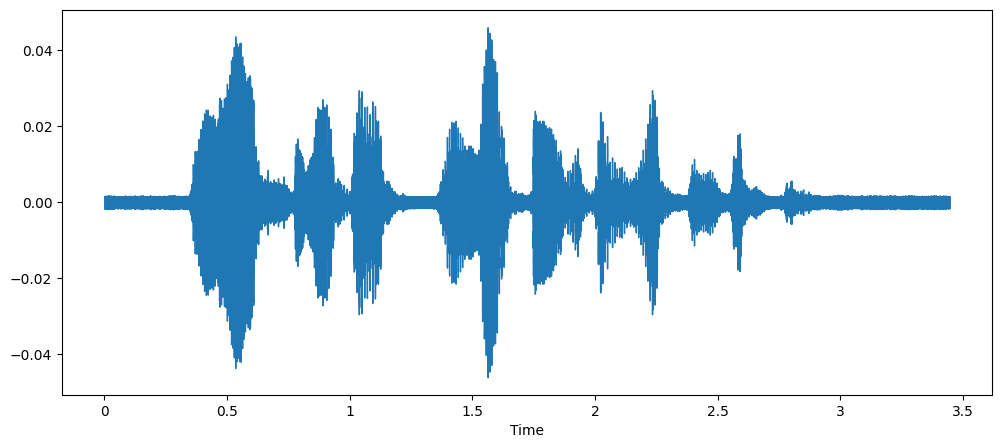

In [23]:
# NORMAL AUDIO


import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

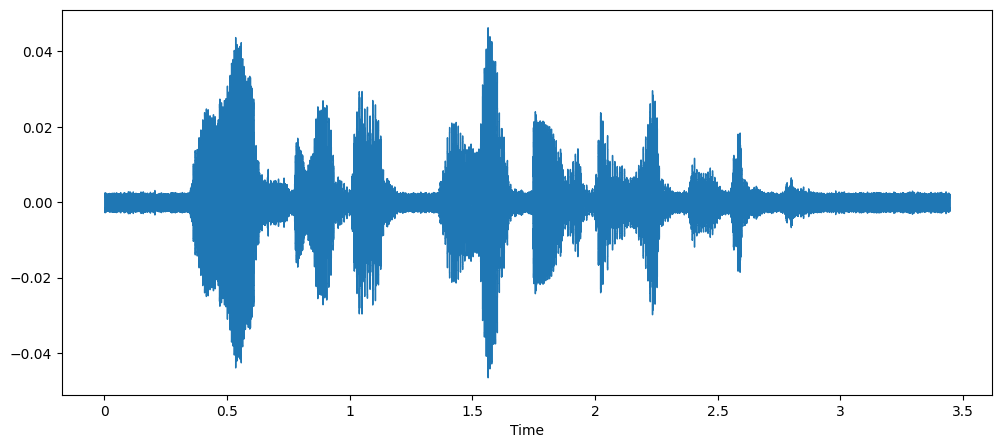

In [24]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

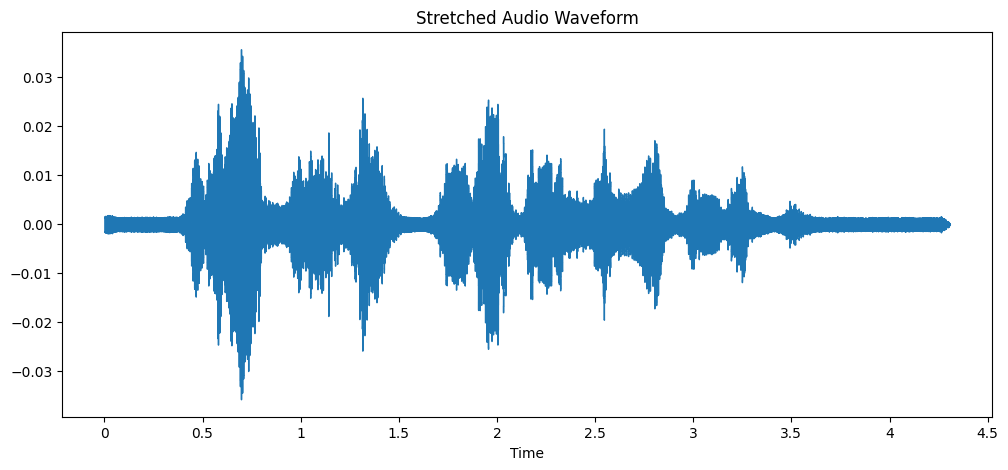

In [25]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

# Corrected STRETCH function
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)  # Explicitly name 'rate'

# Apply stretch (Ensure 'data' and 'sr' are already defined)
x = stretch(data, rate=0.8)

# Plot stretched waveform
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
plt.title("Stretched Audio Waveform")
plt.show()

# Play the stretched audio
ipd.Audio(x, rate=sr)


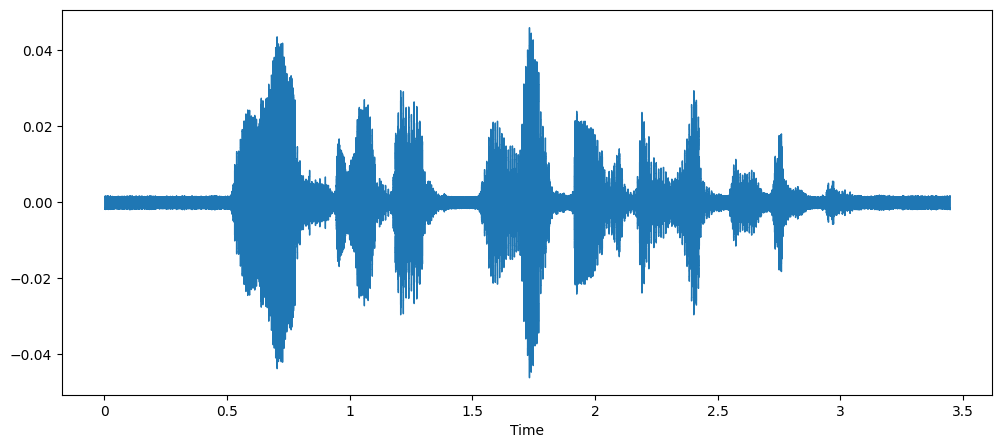

In [26]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

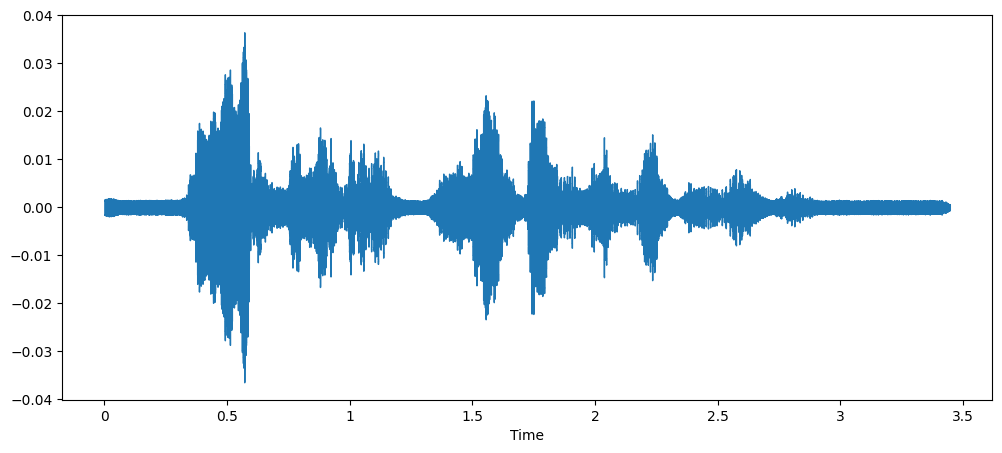

In [27]:
# AUDIO WITH PITCH
x = pitch(data, sr)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

# Feature extraction

In [28]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)

    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))

    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))

    return audio


In [29]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  2


# Noraml way to get features

In [30]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(data_path.Path,data_path.Emotions,range(data_path.Path.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)

2it [00:00, 11.41it/s]

0 audio has been processed


502it [00:53, 11.06it/s]

500 audio has been processed


1002it [01:45,  5.45it/s]

1000 audio has been processed


1504it [02:34, 14.39it/s]

1500 audio has been processed


2002it [03:17,  9.46it/s]

2000 audio has been processed


2503it [03:59, 13.82it/s]

2500 audio has been processed


3003it [04:41, 14.17it/s]

3000 audio has been processed


3503it [05:24, 13.82it/s]

3500 audio has been processed


4001it [06:06, 11.36it/s]

4000 audio has been processed


4503it [06:49, 14.28it/s]

4500 audio has been processed


5002it [07:30, 14.61it/s]

5000 audio has been processed


5502it [08:12, 12.42it/s]

5500 audio has been processed


6002it [08:54, 13.22it/s]

6000 audio has been processed


6502it [09:35, 13.88it/s]

6500 audio has been processed


7001it [10:19,  5.54it/s]

7000 audio has been processed


7502it [11:01, 14.50it/s]

7500 audio has been processed


8002it [11:42, 15.28it/s]

8000 audio has been processed


8502it [12:24, 13.76it/s]

8500 audio has been processed


9004it [13:05, 15.01it/s]

9000 audio has been processed


9504it [13:47, 16.59it/s]

9500 audio has been processed


10003it [14:21, 15.13it/s]

10000 audio has been processed


10504it [14:54, 17.05it/s]

10500 audio has been processed


11005it [15:30, 20.09it/s]

11000 audio has been processed


11503it [16:06, 16.17it/s]

11500 audio has been processed


12003it [16:50, 11.20it/s]

12000 audio has been processed


12162it [17:06, 11.85it/s]

Done
Time:  1026.056651143


In [31]:
"""from joblib import Parallel, delayed
import timeit
start = timeit.default_timer()
# Define a function to get features for a single audio file
def process_feature(path, emotion):
    features = get_features(path)
    X = []
    Y = []
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
    return X, Y

paths = data_path.Path
emotions = data_path.Emotions

# Run the loop in parallel
results = Parallel(n_jobs=-1)(delayed(process_feature)(path, emotion) for (path, emotion) in zip(paths, emotions))

# Collect the results
X = []
Y = []
for result in results:
    x, y = result
    X.extend(x)
    Y.extend(y)


stop = timeit.default_timer()

print('Time: ', stop - start)    """

"from joblib import Parallel, delayed\nimport timeit\nstart = timeit.default_timer()\n# Define a function to get features for a single audio file\ndef process_feature(path, emotion):\n    features = get_features(path)\n    X = []\n    Y = []\n    for ele in features:\n        X.append(ele)\n        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.\n        Y.append(emotion)\n    return X, Y\n\npaths = data_path.Path\nemotions = data_path.Emotions\n\n# Run the loop in parallel\nresults = Parallel(n_jobs=-1)(delayed(process_feature)(path, emotion) for (path, emotion) in zip(paths, emotions))\n\n# Collect the results\nX = []\nY = []\nfor result in results:\n    x, y = result\n    X.extend(x)\n    Y.extend(y)\n\n\nstop = timeit.default_timer()\n\nprint('Time: ', stop - start)    "

In [32]:
len(X), len(Y), data_path.Path.shape


(48648, 48648, (12162,))

# Saving features

In [33]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.385742,0.571289,0.787109,0.718262,0.625000,0.536133,0.447754,0.407715,0.459961,0.550781,...,-19.422245,1.471085,3.112477,-3.113781,10.334204,-29.060032,7.718967,0.164448,-9.481876,neutral
1,0.256836,0.385254,0.519531,0.520508,0.523926,0.520996,0.522461,0.513672,0.514160,0.511719,...,-10.118209,-6.654218,3.391940,2.792983,-0.301091,-17.489977,-0.560359,2.845223,-9.259498,neutral
2,0.282227,0.368652,0.455078,0.376465,0.329102,0.331055,0.325684,0.314941,0.305664,0.274902,...,-17.532406,8.976786,0.837963,-1.579469,-1.820394,-23.618410,11.720230,-12.633018,-8.782503,neutral
3,0.244629,0.375488,0.509766,0.516113,0.513672,0.506836,0.493652,0.486816,0.482910,0.482910,...,-4.269312,-0.943365,6.410807,0.079995,-10.798858,-11.722705,1.676696,-4.822603,-13.856588,neutral
4,0.412109,0.630859,0.818359,0.814453,0.714355,0.632324,0.591797,0.594238,0.659180,0.702637,...,1.784462,4.021106,5.512408,5.471212,4.126155,2.274452,0.630145,-0.529568,-1.312220,neutral


In [34]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.385742,0.571289,0.787109,0.718262,0.625000,0.536133,0.447754,0.407715,0.459961,0.550781,...,-19.422245,1.471085,3.112477,-3.113781,10.334204,-29.060032,7.718967,0.164448,-9.481876,neutral
1,0.256836,0.385254,0.519531,0.520508,0.523926,0.520996,0.522461,0.513672,0.514160,0.511719,...,-10.118209,-6.654218,3.391940,2.792983,-0.301091,-17.489977,-0.560359,2.845223,-9.259498,neutral
2,0.282227,0.368652,0.455078,0.376465,0.329102,0.331055,0.325684,0.314941,0.305664,0.274902,...,-17.532406,8.976786,0.837963,-1.579469,-1.820394,-23.618410,11.720230,-12.633018,-8.782503,neutral
3,0.244629,0.375488,0.509766,0.516113,0.513672,0.506836,0.493652,0.486816,0.482910,0.482910,...,-4.269312,-0.943365,6.410807,0.079995,-10.798858,-11.722705,1.676696,-4.822603,-13.856588,neutral
4,0.412109,0.630859,0.818359,0.814453,0.714355,0.632324,0.591797,0.594238,0.659180,0.702637,...,1.784462,4.021106,5.512408,5.471212,4.126155,2.274452,0.630145,-0.529568,-1.312220,neutral


In [35]:
print(Emotions.isna().any())


0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [36]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(48648, 2377)

In [37]:
np.sum(Emotions.isna())

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


,0
0,0
1,0
2,0
3,0
4,0
...,...
2372,0
2373,0
2374,0
2375,0


# Data preparation

In [38]:
#taking all rows and all cols without last col for X which include features
#taking last col for Y, which include the emotions


X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [39]:
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()


In [40]:
print(Y.shape)
X.shape

(48648, 7)


(48648, 2376)

In [41]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

In [42]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [43]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

In [44]:
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, BatchNormalization, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

# Check TensorFlow version
print("TensorFlow Version:", tf.__version__)


TensorFlow Version: 2.18.0


> Applying early stopping for all models


In [45]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)

In [46]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

# LSTM Model

Model that have lstm layers take alot of time if you have much free time enjoy with it

In [47]:
"""model01=Sequential()
model01.add(LSTM(128,return_sequences=True,input_shape=(x_train.shape[1],1)))
model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.3))
model01.add(LSTM(128))
#model01.add(Dropout(0.3))
model01.add(Dense(7,activation = 'softmax'))
model01.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model01.summary()"""

"model01=Sequential()\nmodel01.add(LSTM(128,return_sequences=True,input_shape=(x_train.shape[1],1)))\nmodel01.add(Dropout(0.2))\nmodel01.add(LSTM(128,return_sequences=True))\n#model01.add(Dropout(0.2))\nmodel01.add(LSTM(128,return_sequences=True))\n#model01.add(Dropout(0.2))\nmodel01.add(LSTM(128,return_sequences=True))\n#model01.add(Dropout(0.2))\nmodel01.add(LSTM(128,return_sequences=True))\n#model01.add(Dropout(0.2))\nmodel01.add(LSTM(128,return_sequences=True))\n#model01.add(Dropout(0.3))\nmodel01.add(LSTM(128))\n#model01.add(Dropout(0.3))\nmodel01.add(Dense(7,activation = 'softmax'))\nmodel01.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])\nmodel01.summary()"

In [48]:
"""hist=model01.fit(X_train, y_train,
            epochs=20,
            validation_data=(X_test, y_test),batch_size=64,
            verbose=1)"""

'hist=model01.fit(X_train, y_train,\n            epochs=20,\n            validation_data=(X_test, y_test),batch_size=64,\n            verbose=1)'

In [49]:
"""print("Accuracy of our model on test data : " , model01.evaluate(X_test,y_test)[1]*100 , "%")
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']
test_acc = hist.history['val_accuracy']
test_loss = hist.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()"""

'print("Accuracy of our model on test data : " , model01.evaluate(X_test,y_test)[1]*100 , "%")\nepochs = [i for i in range(20)]\nfig , ax = plt.subplots(1,2)\ntrain_acc = hist.history[\'accuracy\']\ntrain_loss = hist.history[\'loss\']\ntest_acc = hist.history[\'val_accuracy\']\ntest_loss = hist.history[\'val_loss\']\n\nfig.set_size_inches(20,6)\nax[0].plot(epochs , train_loss , label = \'Training Loss\')\nax[0].plot(epochs , test_loss , label = \'Testing Loss\')\nax[0].set_title(\'Training & Testing Loss\')\nax[0].legend()\nax[0].set_xlabel("Epochs")\n\nax[1].plot(epochs , train_acc , label = \'Training Accuracy\')\nax[1].plot(epochs , test_acc , label = \'Testing Accuracy\')\nax[1].set_title(\'Training & Testing Accuracy\')\nax[1].legend()\nax[1].set_xlabel("Epochs")\nplt.show()'

# CNN model

In [50]:
#Reshape for CNN_LSTM MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape
#x_testcnn[0]

((38918, 2376, 1), (38918, 7), (9730, 2376, 1), (9730, 7))

In [51]:
import tensorflow as tf
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),

    L.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),
    L.Dropout(0.2),  # Fix: Added L.

    L.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),

    L.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),
    L.Dropout(0.2),  # Fix: Added L.

    L.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3, strides=2, padding='same'),
    L.Dropout(0.2),  # Fix: Added L.

    L.Flatten(),
    L.Dense(512, activation='relu'),
    L.BatchNormalization(),
    L.Dense(7, activation='softmax')
])

# Fix: Changed metrics='accuracy' to metrics=['accuracy']
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 2376, 512)           │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2376, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 1188, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 1188, 512)           │       1,311,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1188, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 594, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 594, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 594, 256)            │         655,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 594, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 297, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 297, 256)            │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 297, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 149, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 149, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 149, 128)            │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 149, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 75, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 75, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9600)                │              

 Total params: 7,193,223 (27.44 MB)

 Trainable params: 7,188,871 (27.42 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [52]:
history=model.fit(x_traincnn, y_train, epochs=20, validation_data=(x_testcnn, y_test), batch_size=64,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.3987 - loss: 1.6561

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


609/609 ━━━━━━━━━━━━━━━━━━━━ 180s 263ms/step - accuracy: 0.3988 - loss: 1.6557 - val_accuracy: 0.4882 - val_loss: 1.2739 - learning_rate: 0.0010
Epoch 2/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.5533 - loss: 1.1493

609/609 ━━━━━━━━━━━━━━━━━━━━ 173s 241ms/step - accuracy: 0.5533 - loss: 1.1491 - val_accuracy: 0.5661 - val_loss: 1.1368 - learning_rate: 0.0010
Epoch 3/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.6131 - loss: 1.0171

609/609 ━━━━━━━━━━━━━━━━━━━━ 202s 240ms/step - accuracy: 0.6131 - loss: 1.0170 - val_accuracy: 0.6055 - val_loss: 1.0233 - learning_rate: 0.0010
Epoch 4/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.6558 - loss: 0.8900

609/609 ━━━━━━━━━━━━━━━━━━━━ 200s 237ms/step - accuracy: 0.6559 - loss: 0.8899 - val_accuracy: 0.6337 - val_loss: 0.9753 - learning_rate: 0.0010
Epoch 5/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.7049 - loss: 0.7686

609/609 ━━━━━━━━━━━━━━━━━━━━ 204s 240ms/step - accuracy: 0.7049 - loss: 0.7686 - val_accuracy: 0.6593 - val_loss: 0.9281 - learning_rate: 0.0010
Epoch 6/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.7492 - loss: 0.6643

609/609 ━━━━━━━━━━━━━━━━━━━━ 200s 236ms/step - accuracy: 0.7493 - loss: 0.6643 - val_accuracy: 0.7443 - val_loss: 0.6790 - learning_rate: 0.0010
Epoch 7/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.8177 - loss: 0.4948

609/609 ━━━━━━━━━━━━━━━━━━━━ 204s 240ms/step - accuracy: 0.8177 - loss: 0.4948 - val_accuracy: 0.7710 - val_loss: 0.6323 - learning_rate: 0.0010
Epoch 8/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.8511 - loss: 0.4157

609/609 ━━━━━━━━━━━━━━━━━━━━ 199s 236ms/step - accuracy: 0.8511 - loss: 0.4156 - val_accuracy: 0.7924 - val_loss: 0.5847 - learning_rate: 0.0010
Epoch 9/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.8986 - loss: 0.2899

609/609 ━━━━━━━━━━━━━━━━━━━━ 202s 236ms/step - accuracy: 0.8986 - loss: 0.2898 - val_accuracy: 0.8216 - val_loss: 0.5298 - learning_rate: 0.0010
Epoch 10/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9026 - loss: 0.2773

609/609 ━━━━━━━━━━━━━━━━━━━━ 203s 238ms/step - accuracy: 0.9027 - loss: 0.2771 - val_accuracy: 0.8525 - val_loss: 0.4262 - learning_rate: 0.0010
Epoch 11/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 196s 228ms/step - accuracy: 0.9403 - loss: 0.1772 - val_accuracy: 0.8486 - val_loss: 0.4313 - learning_rate: 0.0010
Epoch 12/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9060 - loss: 0.2807

609/609 ━━━━━━━━━━━━━━━━━━━━ 144s 236ms/step - accuracy: 0.9061 - loss: 0.2804 - val_accuracy: 0.8905 - val_loss: 0.3359 - learning_rate: 0.0010
Epoch 13/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9684 - loss: 0.0950

609/609 ━━━━━━━━━━━━━━━━━━━━ 199s 231ms/step - accuracy: 0.9685 - loss: 0.0950 - val_accuracy: 0.9340 - val_loss: 0.2068 - learning_rate: 0.0010
Epoch 14/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 146s 239ms/step - accuracy: 0.9689 - loss: 0.0957 - val_accuracy: 0.9247 - val_loss: 0.2258 - learning_rate: 0.0010
Epoch 15/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9331 - loss: 0.1903

609/609 ━━━━━━━━━━━━━━━━━━━━ 144s 236ms/step - accuracy: 0.9332 - loss: 0.1901 - val_accuracy: 0.9442 - val_loss: 0.1780 - learning_rate: 0.0010
Epoch 16/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 202s 236ms/step - accuracy: 0.9795 - loss: 0.0621 - val_accuracy: 0.9253 - val_loss: 0.2370 - learning_rate: 0.0010
Epoch 17/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 202s 236ms/step - accuracy: 0.9705 - loss: 0.0878 - val_accuracy: 0.9410 - val_loss: 0.1857 - learning_rate: 0.0010
Epoch 18/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 204s 240ms/step - accuracy: 0.9767 - loss: 0.0699 - val_accuracy: 0.9260 - val_loss: 0.2573 - learning_rate: 0.0010
Epoch 19/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9474 - loss: 0.1606

609/609 ━━━━━━━━━━━━━━━━━━━━ 200s 236ms/step - accuracy: 0.9474 - loss: 0.1604 - val_accuracy: 0.9489 - val_loss: 0.1708 - learning_rate: 0.0010
Epoch 20/20
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9556 - loss: 0.1317

609/609 ━━━━━━━━━━━━━━━━━━━━ 146s 240ms/step - accuracy: 0.9557 - loss: 0.1315 - val_accuracy: 0.9536 - val_loss: 0.1517 - learning_rate: 0.0010


305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9544 - loss: 0.1495
Accuracy of our model on test data :  95.36485075950623 %


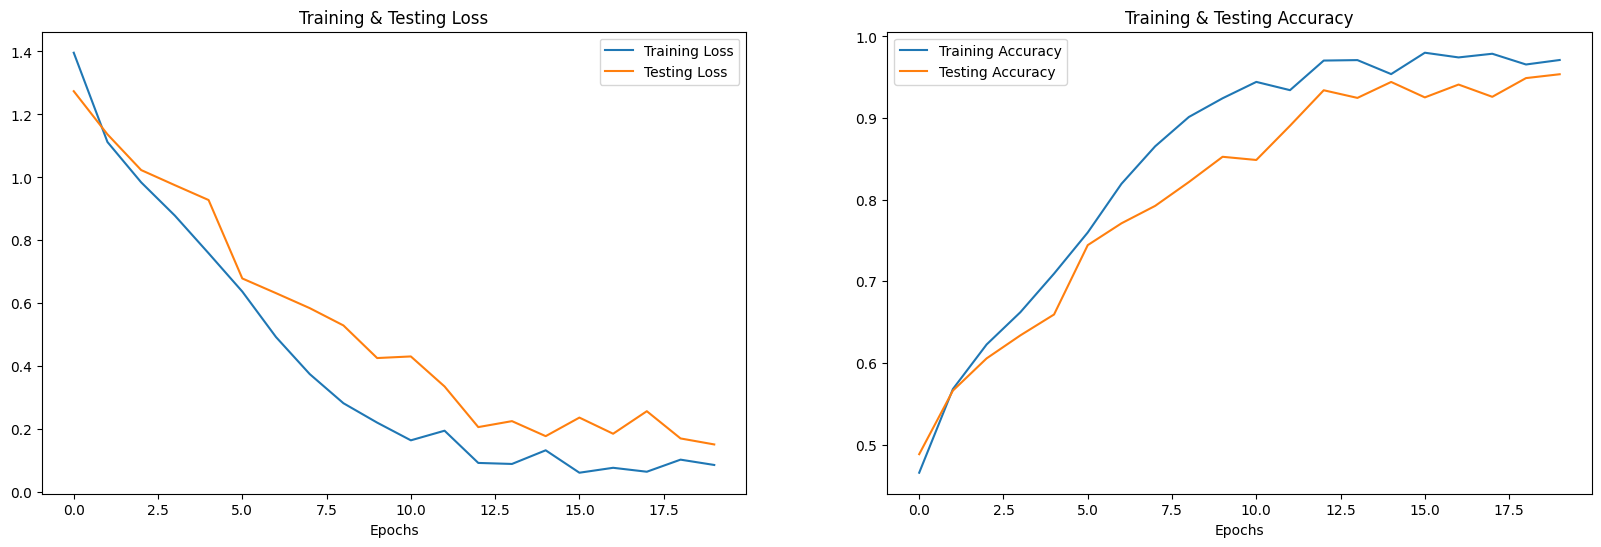

In [54]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

# Get the actual number of epochs from history
epochs = range(len(history.history['accuracy']))  # Adjust to match training length

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 6)

# Training & Testing Loss Plot
ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, test_loss, label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

# Training & Testing Accuracy Plot
ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, test_acc, label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

plt.show()


In [55]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

305/305 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step


,Predicted Labels,Actual Labels
0,neutral,neutral
1,angry,angry
2,happy,happy
3,sad,sad
4,happy,happy
5,disgust,disgust
6,sad,sad
7,angry,angry
8,disgust,disgust
9,neutral,neutral


In [56]:
df0

,Predicted Labels,Actual Labels
0,neutral,neutral
1,angry,angry
2,happy,happy
3,sad,sad
4,happy,happy
...,...,...
9725,disgust,disgust
9726,neutral,neutral
9727,sad,sad
9728,surprise,surprise


# Evalutation

Results of best model

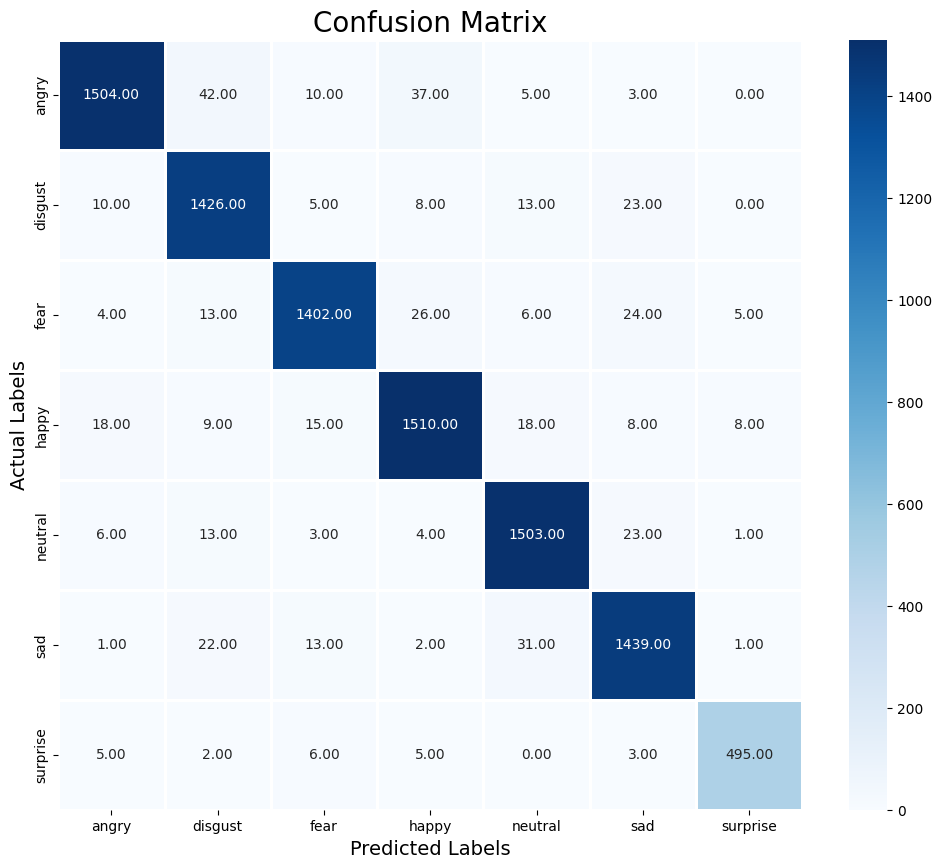

              precision    recall  f1-score   support

       angry       0.97      0.94      0.96      1601
     disgust       0.93      0.96      0.95      1485
        fear       0.96      0.95      0.96      1480
       happy       0.95      0.95      0.95      1586
     neutral       0.95      0.97      0.96      1553
         sad       0.94      0.95      0.95      1509
    surprise       0.97      0.96      0.96       516

    accuracy                           0.95      9730
   macro avg       0.96      0.95      0.95      9730
weighted avg       0.95      0.95      0.95      9730



In [57]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

# Saving Best Model

In [59]:
from tensorflow.keras.models import Sequential, model_from_json

# Serialize model to JSON
model_json = model.to_json()
with open("CNN_model.json", "w") as json_file:
    json_file.write(model_json)

# Serialize weights to HDF5 (fix filename issue)
model.save_weights("CNN_model_weights.weights.h5")

print("Saved model to disk")


Saved model to disk


In [61]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('/content/CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/CNN_model_weights.weights.h5")
print("Loaded model from disk")

Loaded model from disk


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 28 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [62]:
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn,y_test)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

305/305 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.9544 - loss: 0.1495
compile_metrics: 95.36%


# Saving and Loading our Stnadrad Scaler and encoder
* To save the StandardScaler object to use it later in a Flask API

pickle file


In [63]:
import pickle

# Saving scaler
with open('scaler2.pickle', 'wb') as f:
    pickle.dump(scaler, f)

# Loading scaler
with open('scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

# Saving encoder
with open('encoder2.pickle', 'wb') as f:
    pickle.dump(encoder, f)

# Loading encoder
with open('encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)


print("Done")

Done


# Test script
* That can predict new record

In [64]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('/content/CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/CNN_model_weights.weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [65]:
import pickle

with open('/content/scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

with open('/content/encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)


print("Done")

Done


In [66]:
import librosa

In [84]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=256):
    rmse=librosa.feature.rms(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=256,flatten:bool=True):
    mfcc=librosa.feature.mfcc(data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=256):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

In [85]:
def get_predict_feat(path):
    d, s_rate= librosa.load(path, duration=2.5, offset=0.6)
    res=extract_features(d)
    result=np.array(res)
    result=np.reshape(result,newshape=(1,2376))
    i_result = scaler2.transform(result)
    final_result=np.expand_dims(i_result, axis=2)

    return final_result

In [87]:
import librosa
import numpy as np

def rmse(data, frame_length=2048, hop_length=256):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

# Example: Load audio and extract RMSE
y, sr = librosa.load("/content/Ravdess/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav")
res = rmse(y)
print(res.shape)


(285,)


In [108]:
import numpy as np
import librosa

# Feature extraction functions
def zcr(data, frame_length, hop_length):
    zcr = librosa.feature.zero_crossing_rate(data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(data, frame_length=2048, hop_length=256):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

def mfcc(data, sr, frame_length=2048, hop_length=256, flatten=True):
    mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13, n_fft=frame_length, hop_length=hop_length)
    return np.ravel(mfcc.T) if flatten else np.squeeze(mfcc)

def extract_features(data, sr=22050, frame_length=2048, hop_length=256):
    result = np.array([])

    # Extract ZCR, RMSE, and MFCC features
    zcr_features = zcr(data, frame_length, hop_length)
    rmse_features = rmse(data, frame_length, hop_length)
    mfcc_features = mfcc(data, sr, frame_length, hop_length)

    # Stack all features together
    result = np.hstack((result, zcr_features, rmse_features, mfcc_features))
    print("Extracted Feature Shape:", result.shape)
    return result

def get_predict_feat(path):
    # Load the audio file
    d, s_rate = librosa.load(path, duration=2.5, offset=0.6)

    # Extract features from the audio
    features = extract_features(d, s_rate)

    return features

# Emotions dictionary for output
emotions1 = {1: 'Neutral', 2: 'Calm', 3: 'Happy', 4: 'Sad', 5: 'Angry', 6: 'Fear', 7: 'Disgust', 8: 'Surprise'}

def prediction_2(path1):
    # Extract features from the audio file
    res = get_predict_feat(path1)
    print("Extracted Feature Shape before any reshaping:", res.shape)  # Debugging output

    required_features = 2376  # The number of features your model expects

    # Check if the number of features is as expected
    if res.shape[0] != required_features:
        print(f"Feature vector size mismatch: {res.shape[0]} (expected {required_features})")

        # If the feature vector has fewer than 2376 features, pad it with zeros
        if res.shape[0] < required_features:
            print(f"Padding with {required_features - res.shape[0]} zeros.")
            res = np.pad(res, (0, required_features - res.shape[0]), mode='constant')
        # If the feature vector has more than 2376 features, truncate it
        elif res.shape[0] > required_features:
            print(f"Truncating to {required_features} features.")
            res = res[:required_features]

    # Now the feature vector should be of the correct size
    print("Feature Shape after adjustment:", res.shape)

    # Reshape the feature vector for prediction (model expects 2D input)
    res = res.reshape(1, -1)

    # Make predictions using the loaded model
    predictions = loaded_model.predict(res)

    # Ensure that predictions are a 2D array
    predictions = predictions.reshape(-1, 1)  # Ensuring it's 2D

    print("Predictions shape:", predictions.shape)

    # Convert the predictions to actual emotion labels
    try:
        y_pred = encoder2.inverse_transform(predictions)
        print("Predicted Emotion:", y_pred[0][0])
    except ValueError as e:
        print(f"Error in inverse_transform: {e}")
        print(f"Predictions: {predictions}")

# Call the function with the path to your audio file
prediction_2("/content/Ravdess/audio_speech_actors_01-24/Actor_01/03-01-01-01-02-02-01.wav")


Extracted Feature Shape: (3240,)
Extracted Feature Shape before any reshaping: (3240,)
Feature vector size mismatch: 3240 (expected 2376)
Truncating to 2376 features.
Feature Shape after adjustment: (2376,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Predictions shape: (7, 1)
Error in inverse_transform: Shape of the passed X data is not correct. Expected 7 columns, got 1.
Predictions: [[0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [110]:
import numpy as np
import librosa

# Feature extraction functions
def zcr(data, frame_length, hop_length):
    zcr = librosa.feature.zero_crossing_rate(data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(data, frame_length=2048, hop_length=256):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

def mfcc(data, sr, frame_length=2048, hop_length=256, flatten=True):
    mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13, n_fft=frame_length, hop_length=hop_length)
    return np.ravel(mfcc.T) if flatten else np.squeeze(mfcc)

def extract_features(data, sr=22050, frame_length=2048, hop_length=256):
    result = np.array([])

    # Extract ZCR, RMSE, and MFCC features
    zcr_features = zcr(data, frame_length, hop_length)
    rmse_features = rmse(data, frame_length, hop_length)
    mfcc_features = mfcc(data, sr, frame_length, hop_length)

    # Stack all features together
    result = np.hstack((result, zcr_features, rmse_features, mfcc_features))
    print("Extracted Feature Shape:", result.shape)
    return result

def get_predict_feat(path):
    # Load the audio file
    d, s_rate = librosa.load(path, duration=2.5, offset=0.6)

    # Extract features from the audio
    features = extract_features(d, s_rate)

    return features

# Emotions dictionary for output
emotions1 = {1: 'Neutral', 2: 'Calm', 3: 'Happy', 4: 'Sad', 5: 'Angry', 6: 'Fear', 7: 'Disgust', 8: 'Surprise'}

def prediction_2(path1):
    # Extract features from the audio file
    res = get_predict_feat(path1)
    print("Extracted Feature Shape before any reshaping:", res.shape)  # Debugging output

    required_features = 2376  # The number of features your model expects

    # Check if the number of features is as expected
    if res.shape[0] != required_features:
        print(f"Feature vector size mismatch: {res.shape[0]} (expected {required_features})")

        # If the feature vector has fewer than 2376 features, pad it with zeros
        if res.shape[0] < required_features:
            print(f"Padding with {required_features - res.shape[0]} zeros.")
            res = np.pad(res, (0, required_features - res.shape[0]), mode='constant')
        # If the feature vector has more than 2376 features, truncate it
        elif res.shape[0] > required_features:
            print(f"Truncating to {required_features} features.")
            res = res[:required_features]

    # Now the feature vector should be of the correct size
    print("Feature Shape after adjustment:", res.shape)

    # Reshape the feature vector for prediction (model expects 2D input)
    res = res.reshape(1, -1)

    # Make predictions using the loaded model
    predictions = loaded_model.predict(res)

    # Ensure that predictions are a 2D array
    predictions = predictions.reshape(-1, 1)  # Ensuring it's 2D

    print("Predictions shape:", predictions.shape)

    # Assuming that the model's output is an integer index representing the emotion class
    predicted_class_index = predictions[0][0]  # Get the predicted class index
    print(f"Predicted class index: {predicted_class_index}")

    # Map the predicted index to the emotion label
    if 0 <= predicted_class_index < len(emotions1):
        predicted_emotion = emotions1[predicted_class_index + 1]  # Adjusting index to match emotions1
        print("Predicted Emotion:", predicted_emotion)
    else:
        print("Error: Predicted index out of bounds")

# Call the function with the path to your audio file
prediction_2("/content/Ravdess/audio_speech_actors_01-24/Actor_01/03-01-01-01-02-02-01.wav")


Extracted Feature Shape: (3240,)
Extracted Feature Shape before any reshaping: (3240,)
Feature vector size mismatch: 3240 (expected 2376)
Truncating to 2376 features.
Feature Shape after adjustment: (2376,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Predictions shape: (7, 1)
Predicted class index: 0.0
Predicted Emotion: Neutral


In [115]:
import numpy as np
import librosa
import pickle
from tensorflow.keras.models import model_from_json

# Load the model and its weights
json_file = open('/content/CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("/content/CNN_model_weights.weights.h5")
print("Loaded model from disk")

# Load the scaler and encoder
with open('/content/scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

with open('/content/encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)

# Feature extraction functions
def zcr(data, frame_length, hop_length):
    zcr = librosa.feature.zero_crossing_rate(data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(data, frame_length=2048, hop_length=256):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

def mfcc(data, sr, frame_length=2048, hop_length=256, flatten=True):
    mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13, n_fft=frame_length, hop_length=hop_length)
    return np.ravel(mfcc.T) if flatten else np.squeeze(mfcc)

def extract_features(data, sr=22050, frame_length=2048, hop_length=256):
    result = np.array([])

    # Extract ZCR, RMSE, and MFCC features
    zcr_features = zcr(data, frame_length, hop_length)
    rmse_features = rmse(data, frame_length, hop_length)
    mfcc_features = mfcc(data, sr, frame_length, hop_length)

    # Stack all features together
    result = np.hstack((result, zcr_features, rmse_features, mfcc_features))
    print("Extracted Feature Shape:", result.shape)
    return result

def get_predict_feat(path):
    # Load the audio file
    d, s_rate = librosa.load(path, duration=2.5, offset=0.6)

    # Extract features from the audio
    features = extract_features(d, s_rate)

    return features

# Emotions dictionary for output
emotions1 = {1: 'Neutral', 2: 'Calm', 3: 'Happy', 4: 'Sad', 5: 'Angry', 6: 'Fear', 7: 'Disgust', 8: 'Surprise'}

def prediction_2(path1):
    # Extract features from the audio file
    res = get_predict_feat(path1)
    print("Extracted Feature Shape before any reshaping:", res.shape)  # Debugging output

    required_features = 2376  # The number of features your model expects

    # Check if the number of features is as expected
    if res.shape[0] != required_features:
        print(f"Feature vector size mismatch: {res.shape[0]} (expected {required_features})")

        # If the feature vector has fewer than 2376 features, pad it with zeros
        if res.shape[0] < required_features:
            print(f"Padding with {required_features - res.shape[0]} zeros.")
            res = np.pad(res, (0, required_features - res.shape[0]), mode='constant')
        # If the feature vector has more than 2376 features, truncate it
        elif res.shape[0] > required_features:
            print(f"Truncating to {required_features} features.")
            res = res[:required_features]

    # Now the feature vector should be of the correct size
    print("Feature Shape after adjustment:", res.shape)

    # Apply scaling using scaler2
    res = scaler2.transform(res.reshape(1, -1))  # Reshape and scale
    print("Feature Shape after scaling:", res.shape)
    print("Scaled features:", res)

    # Reshape the feature vector for prediction (model expects 2D input)
    res = res.reshape(1, -1)

    # Make predictions using the loaded model
    predictions = loaded_model.predict(res)

    # Ensure that predictions are a 2D array
    predictions = predictions.reshape(-1, 1)  # Ensuring it's 2D

    print("Predictions shape:", predictions.shape)

    # Check predicted probabilities (if model is giving softmax outputs)
    print("Predictions (Probabilities):", predictions)

    # Convert the predictions to actual emotion labels
    try:
        predicted_class_index = np.argmax(predictions, axis=1)[0]  # Get the predicted class index
        print(f"Predicted class index: {predicted_class_index}")

        # Map the predicted index to the emotion label
        if 0 <= predicted_class_index < len(emotions1):
            predicted_emotion = emotions1[predicted_class_index + 1]  # Adjusting index to match emotions1
            print("Predicted Emotion:", predicted_emotion)
        else:
            print("Error: Predicted index out of bounds")

    except Exception as e:
        print(f"Error in prediction or mapping: {e}")
        print(f"Predictions: {predictions}")

# Call the function with the path to your audio file
prediction_2("/content/Ravdess/audio_speech_actors_01-24/Actor_01/03-01-01-01-02-02-01.wav")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 28 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Loaded model from disk
Extracted Feature Shape: (3240,)
Extracted Feature Shape before any reshaping: (3240,)
Feature vector size mismatch: 3240 (expected 2376)
Truncating to 2376 features.
Feature Shape after adjustment: (2376,)
Feature Shape after scaling: (1, 2376)
Scaled features: [[2.47810918 1.90313875 1.97807845 ... 5.9042479  5.81296323 4.02806103]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step
Predictions shape: (7, 1)
Predictions (Probabilities): [[6.4283133e-23]
 [1.0769215e-02]
 [6.5699777e-21]
 [2.2724163e-14]
 [3.7254835e-20]
 [2.2716017e-10]
 [9.8923081e-01]]
Predicted class index: 0
Predicted Emotion: Neutral


In [111]:
prediction("/content/Ravdess/audio_speech_actors_01-24/Actor_01/03-01-01-01-02-02-01.wav")
prediction_2("/content/Ravdess/audio_speech_actors_01-24/Actor_01/03-01-01-01-02-02-01.wav")

Original shape: ()
Reshaped features shape: (1, 1)
Prediction successful!
Extracted Feature Shape: (3240,)
Extracted Feature Shape before any reshaping: (3240,)
Feature vector size mismatch: 3240 (expected 2376)
Truncating to 2376 features.
Feature Shape after adjustment: (2376,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predictions shape: (7, 1)
Predicted class index: 0.0
Predicted Emotion: Neutral


In [116]:
prediction_2("/content/Ravdess/audio_speech_actors_01-24/Actor_07/03-01-01-01-01-01-07.wav")

Extracted Feature Shape: (3240,)
Extracted Feature Shape before any reshaping: (3240,)
Feature vector size mismatch: 3240 (expected 2376)
Truncating to 2376 features.
Feature Shape after adjustment: (2376,)
Feature Shape after scaling: (1, 2376)
Scaled features: [[ 4.19986717  3.4384443   3.0903004  ...  9.92034714 -0.4180159
  -6.50577947]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Predictions shape: (7, 1)
Predictions (Probabilities): [[1.5549979e-16]
 [7.8100911e-06]
 [6.3130170e-21]
 [2.7881426e-14]
 [8.2533977e-17]
 [1.3893882e-25]
 [9.9999213e-01]]
Predicted class index: 0
Predicted Emotion: Neutral
